# Visualizing the Variability of Sea Surface Temperatures in the Northern Pacific Using a Rasberry Pi

The goal of this project was to visualize the variability of sea surface temperature in the northern Pacific economically. This was achieved using public data from the Jet Propulsion Laboratory, California Institute of Technology, MUR SST project, and running code with the Massachusetts Green High Computing Center, which was accessed remotely on a Raspberry Pi. The code was written in Python.

### Big Picture (Master Research Project)
The results of this notebook are a part of the project "Signatures of the multiple scales of motion in shaping marine phytoplankton biogeography", whose goal is, as described by its proposal, "to address the nature of the interplay between ocean dynamics and marine plankton community structure." The research involves looking at different phsyical behaivors of the ocean compared with the behaivor of phytoplankton populations, specifically in the region between Hawaii and southwest Alaska. The data used for this project are sourced from satelites as well as field samples, gathered by teams of researchers "in-situ" (aboard a ship).

> Read more about the project: https://globalchange.mit.edu/research/research-projects/signatures-multiple-scales-motion-shaping-marine-phytoplankton


### Smaller Picture (My Project)
Using sea surface temperatures collected by the Jet Propulsion Laboratory, California Institute of Technology, MUR SST project, three plots were created to visaulize the variabilty of sea surface temperatures. First, the data were extracted from files stored at the MGHPCC and stored into an array (sst). Then the data were convolved: put through a filter that reassigned each array element to the average of the 81 elements around it (9x9 square). Those values were then stored in a new array (conv). Each element of "conv" was subtracted from the corresponding element of "sst", and the difference was stored into a final array (diff). The plotted difference reveals what areas of the ocean have the most regional variability in its sea surface temperature.

> Read more about MUR SST: https://mur.jpl.nasa.gov/index.php  
> Read more about MGHPCC: https://www.mghpcc.org/

Additionaly, this project can be done for around 100 dollars, provided one does not already own any of the required materials. If one only needs to purchase the Raspberry Pi, the price drops to ~35 dollars. This provides an example as to how one can make supercomputing more afforable, and thus more accessible.

> Read more about the Raspberry Pi: https://www.raspberrypi.org/  

___
## Textbook
My only background coming into this project was an intro to computing class (Comp11 at Tufts University), which covered the *very* basics of python, however was mostly focused on C++. Thus, in order to complete this project, I spent much of my first month researching and taking online courses.  
The following links acted as my core "textbook":
* Edx Python course based on the first part of the intro to computer science class (6.00) at MIT 
  * https://www.edx.org/course/introduction-to-computer-science-and-programming-using-python
* Linux course from The Linux Foundation, useful for linux navigation when accessing MGHPCC
  * https://courses.edx.org/courses/course-v1:LinuxFoundationX+LFS101x+1T2017/course/
* Git-it: a git tutorial, for all that code sharing
  * https://github.com/jlord/git-it-electron
* NetCDF helper links (NetCDF is a very complex and confusing format for a new programmer [at least for me], and thus I spent a lot of time trying to understand its structure in order to access its data)
  * documentation: https://www.unidata.ucar.edu/software/netcdf/docs/
  * a doc I found more readable: http://unidata.github.io/netcdf4-python/
___

## Making plots

### First Thing's First

We have lots of modules to import:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import netCDF4
import astropy
import scipy
import calendar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.convolution import convolve as ap_convolve
from astropy.convolution import Box2DKernel
from matplotlib.axes import Axes
from netCDF4 import num2date
from scipy import stats

The data files that contain the MUR SST data are in Network Common Data form (netCDF). NetCDF files are structured similarly to the Unix file system, with a designated file acting as the "root group". The following function extracts data from the file by returning a tuple of information: an array of sea surface temperatures, the date the data was collected, the maximumm and minimum of the longitude and latitude values of the data.

In [3]:
def extract_data(file):
    # Extract data from file
    sst=file['analysed_sst']
    date_num = file['time'][:]
    units = file.variables['time'].units
    date = num2date(date_num, units)[0]
    date = str(date)
    date = date[:10]

    # Extract a subregion
    sstReg=sst[0, ylo:yhi, xlo:xhi]-273.

    # Extract coordinate data
    lat = file.variables['lat']
    lon = file.variables['lon']
    latmin = (ylo/100) + lat.valid_min
    lonmin = (xlo/100) + lon.valid_min
    latmax = (yhi/100) + lat.valid_min
    lonmax = (xhi/100) + lon.valid_min
    file_info = (sstReg, date, latmin, lonmin, latmax, lonmax)
    return file_info

The region the researcher would like to view is specified, and the desired file is set to be the root group. The extract_data function retrieves data from the file. 

*For these examples, we will be looking at data from the file "20130109090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"*

In [4]:
os.chdir('/nfs/cnhlab003/cnh/mur-sst')

# Choose x and y range
yhi = 15000
ylo = 10800
xhi = 3500
xlo = 1000

tFile = netCDF4.Dataset('20111118090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')
tFile_info=extract_data(tFile)
sstReg, date=tFile_info[0], tFile_info[1]
latmin, lonmin=tFile_info[2], tFile_info[3]
latmax, lonmax=tFile_info[4], tFile_info[5]

The make_plot function's parameters are an sst array, the number associated with its location for the subplot function (use None if a single plot), the desired colormap, the title, and the max and min values for normalization. Prints a plot of data and returns nothing.
> matplotlib.pyplot.subplot() documentation: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html

In [5]:
def make_plot(data, num, cc, plttitle, vmin_val, vmax_val):
    if num == None:
        fig=plt.imshow(data, origin='lower', cmap=cc, vmin=vmin_val, vmax=vmax_val)
        plt.xticks([0, xhi-xlo], [lonmin, lonmax])
        plt.yticks([0, (yhi-ylo)/2, yhi-ylo], [latmin, ((latmax-latmin)/2)+latmin, latmax])
        plt.tick_params(axis='both', labelsize=7)
        plt.title(plttitle, size=14)
        plt.colorbar(fig)
    else:
        ax=plt.subplot(num)
        fig=plt.imshow(data, origin='lower', cmap=cc, vmin=vmin_val, vmax=vmax_val)
        plt.xticks([0, xhi-xlo], [lonmin, lonmax])
        plt.yticks([0, (yhi-ylo)/2, yhi-ylo], [latmin, ((latmax-latmin)/2)+latmin, latmax])
        ax.tick_params(axis='both', labelsize=7)
        plt.title(plttitle, size=10)

        # Make colorbar lined up with figure and resize label
        divider=make_axes_locatable(ax)
        cax=divider.append_axes("right", size="5%", pad=0.05)
        cbar=plt.colorbar(fig, cax=cax)
        ticklabs=cbar.ax.get_yticklabels()
        cbar.ax.set_yticklabels(ticklabs, fontsize=7)

### SST Plot
The sea surface temperature array (sstReg) is passed into the make_plot function. Here, two plots are made. One with a repeating color map to create a more detailed visual of the varying temperature, the other with a non-repeating color map that makes understanding the temperatures of the regions easier. Temperatures are in celsius.

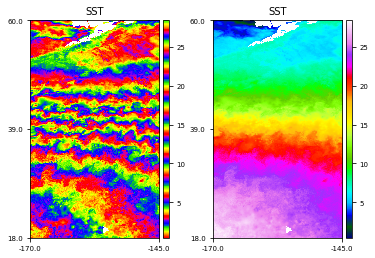

In [7]:
make_plot(sstReg, 121, 'prism', 'SST', None, None)
make_plot(sstReg, 122, 'gist_ncar', 'SST', None, None)

### Convolved Sea Surface Temperature Plot
The conv_for_vis function take two parameters: an array of data and a kernel size. The kernel size is passed into the Box2DKernel function, which creates a kernel that can be used in the ap_convolve function. The parameter determines the size of the smoothing filter. The function returns a convolution of the array passed in.
> astropy.convolution.convolve() (ap_convolve) documentation: http://docs.astropy.org/en/stable/api/astropy.convolution.convolve.html
> astropy.convolution.Box2DKernel() documentation: http://docs.astropy.org/en/stable/api/astropy.convolution.Box2DKernel.html

In [8]:
def conv_for_vis(data, size):
    box_2D_kernel = Box2DKernel(size)
    nan=float('nan')
    data=np.ma.filled(data,nan)
    data[ :, 0]=nan
    data[ 0, :]=nan
    data[ :,-1]=nan
    data[-1, :]=nan
    data2=ap_convolve(data, box_2D_kernel)
    conv=data2
    conv=conv[size:-size, size:-size]
    conv=np.ma.masked_invalid(conv)
    return conv

For this project, we used a kernel size of nine. This means that each point in the resulting array is the value of the average of the 81 points surrounding the point in the original array. It is a small smooting filter, and the difference appears subtle. In the following plots created using the make_plot function, the difference between conv and sst is most easily visible around the land masses, specifically Alaska. 

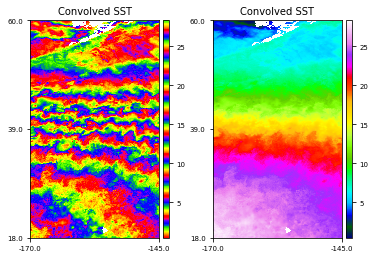

In [9]:
conv = conv_for_vis(sstReg, 9)
make_plot(conv, 121, 'prism', 'Convolved SST', None, None)
make_plot(conv, 122, 'gist_ncar', 'Convolved SST', None, None)

### Difference Plot
The differences between the two arrays become much clearer when the convolved data is subtracted from the original. The first plot shows a non-normalized plot of the data, which is not very useful in that the extremes are throwing off the visual. The second is normalized by +/- 0.1. The greenish yellow color is 0, thus the areas that are mostly that color have relatively constant temperature, and do not vary drastically. The areas with more color varaition have more temperature variation as well.

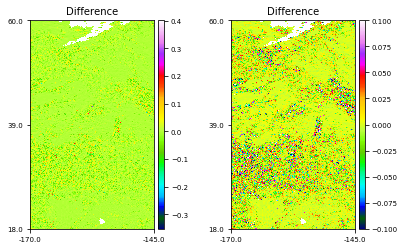

In [12]:
sstReg=sstReg[9:-9, 9:-9]
dif = sstReg - conv
make_plot(dif, 121, 'gist_ncar',  'Difference', None, None)
make_plot(dif, 122, 'gist_ncar',  'Difference', -0.1, 0.1)
plt.subplots_adjust(wspace = 0.5)

___
## Histograms
Histograms are included in the final image so as to help the viewer understand the data quantitatively. The make_hist function's parameters are an array of data and a number for the subplot function. The function prints a histogram and returns nothing.

In [10]:
def make_hist(data, num):
    if num != None:
        ax = plt.subplot(num)
        ax.tick_params(axis='both', labelsize=7)
    phi = data.flatten()
    hist = plt.hist(phi, bins=50)
        
    # sst labels change to phi see if no str works, look at format statments
    dmax = np.nanmax(phi)
    dmin = np.nanmin(phi)
    dmean = np.nanmean(phi)    
    dstd = np.nanstd(phi)
    dskew = stats.mstats.skew(phi, axis=None)
    dkurt = stats.mstats.kurtosis(phi, axis=None)
    plt.xlabel(f'max: {dmax:.3f}\n min: {dmin:.3f}\n mean: {dmean:.3f}\n std: {dstd:.3f}\n skew: {dskew:.3f}\n kurtosis: {dkurt:.3f}', size=7)

A histogram example:

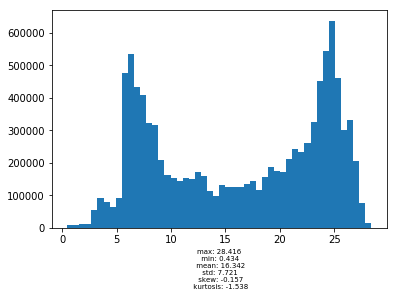

In [12]:
make_hist(sstReg, None)

___
## Final

This loop was used to create plots the data of an entire year, saving each plot into a folder corresponding to its month. The if statement read 'if filename[:4] == '2012':' For the purpose of this notebook, only three figures are printed, thus the if statement is altered.  
Each figure includes the sea surface temperature plot, the convolved plot, and the difference plot, as well as histograms and statistics for each dataset.

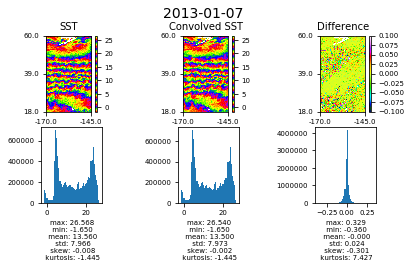

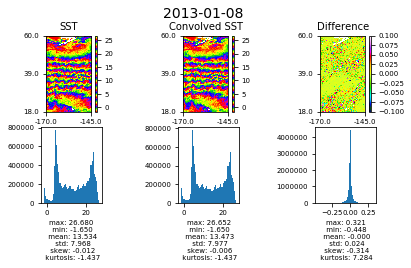

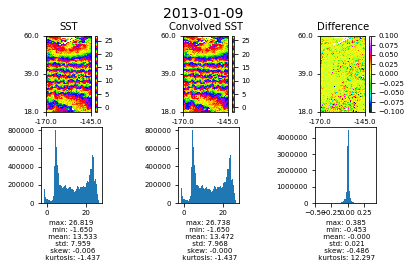

<Figure size 432x288 with 0 Axes>

In [14]:
# Ignore runtime warning
import warnings
warnings.filterwarnings('ignore')

os.chdir('/nfs/cnhlab003/cnh')
for filename in os.listdir('mur-sst'):
        if filename[:8] == '20130109' or filename[:8] == '20130108' or filename[:8] == '20130107':   
            boxsize=9

            # Choose x and y range
            yhi = 15000
            ylo = 10800
            xhi = 3500
            xlo = 1000

            # Create "handle" to access netCDF file
            tFile = netCDF4.Dataset('mur-sst/'+filename)
            extract_data(tFile)
            
            tFile_info=extract_data(tFile)
            sstReg, date=tFile_info[0], tFile_info[1]
            latmin, lonmin=tFile_info[2], tFile_info[3]
            latmax, lonmax=tFile_info[4], tFile_info[5]
            
            # Make sst data plots
            make_plot(sstReg, 231, 'prism', 'SST', None, None)
            make_hist(sstReg, 234)

            # Convolve sst data
            conv = conv_for_vis(sstReg, boxsize)

            # Make convolved data plots
            make_plot(conv, 232, 'prism', 'Convolved SST', None, None)
            make_hist(conv, 235)

            # Find difference between original and convolved data
            sstReg=sstReg[boxsize:-boxsize, boxsize:-boxsize]
            dif = sstReg - conv

            # Difference data plots
            make_plot(dif, 233, 'gist_ncar',  'Difference', -0.1, 0.1)
            dif = dif[np.logical_not(np.isnan(dif))] # Removes nan values from histogram
            make_hist(dif, 236)

            # Format plots
            plt.suptitle(date, fontsize=14)
            plt.subplots_adjust(wspace = 1.25, bottom = 0.3)

            # Save and show fig
            month = calendar.month_name[int(filename[4:6])]
            os.chdir('/home/culberta/public_html/sstconvdif-imgs-2012/'+month)
            plt.savefig(str(date) + '.png', dpi = 200)
            plt.show()
            plt.clf()
            os.chdir('/nfs/cnhlab003/cnh')